In [1]:
# from deap import base, creator, tools, algorithms
from dedalus import public as de
from dedalus.extras.plot_tools import plot_bot_2d
from dedalus.extras import *
import numpy as np
import scipy
from scipy import integrate
import pickle
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import time as timeski
import os

#Suppress most Dedalus output
de.logging_setup.rootlogger.setLevel('ERROR')

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'arial'
# rcParams['font.sans-serif'] = ['Tahoma']
rcParams.update({'font.size': 16})

In [11]:
### Functions for simulations
def scale(A):
    #Scale list between 0 and 1
    return (A-np.min(A))/(np.max(A) - np.min(A))

# steady state ODE
def ssODE_simple(y, t,params):
    A = y
    k,delta = params
    
    dA = k - delta*A

    return dA

#determine homogenous SS using ssODE
def homogenousSS_simple(params):

    t_sim = (0,1000)
    odeSoln = integrate.odeint(ssODE_simple,0,t_sim,args=(params,),mxstep=1000000) 
      
    return(odeSoln[1])

def simple_diffusion(params):
    k_s,k_p,delta,Du = params

    #Bases:names,modes,intervals,dealiasing
    r_basis=de.Chebyshev('r',1024,interval=(0,4),dealias=3/2)
    #Domain:bases,datatype
    domain=de.Domain([r_basis],float)
    r = domain.grids(scales=1)

    mu_F = 1.75

    k = domain.new_field(name='k')

    k['g'] = [k_p if curr_r < mu_F else k_s for curr_r in r[0]]

    p_ss = [k_s,delta]
    u0 = homogenousSS_simple(p_ss)

    # Specify problem
    problem = de.IVP(domain, variables=['u', 'ur'])

    problem.parameters['k'] = k
    problem.parameters['Du'] = Du
    problem.parameters['delta'] = delta

    problem.substitutions['f(u)'] = 'k - delta*u'
    problem.substitutions['minf(u)'] = '-f(u)'

    problem.add_equation("r*dt(u)-r*Du*dr(ur)-Du*dr(u)=r*f(u)")
    problem.add_equation("ur-dr(u)=0")


    # # Neumann boundary conditions
    problem.add_bc("left (ur) = 0")
    problem.add_bc("right (ur) = 0")


    # Pick a timestepper
    ts = de.timesteppers.RK443 #RK222
    # Build solver
    solver = problem.build_solver(ts)
    # Set integration limits
    solver.stop_wall_time = np.inf
    solver.stop_sim_time = np.inf
    solver.stop_iteration = np.inf
    # Set initial conditions
    u = solver.state ['u']

    u['g'] = u0

    solver.stop_iteration = 1000 

    dt = 0.01 #0.25
    nonan = True
    # curr_t = 0
    # Main loop chceking stopping criteria
    while solver.ok and nonan:
        # Step forward
        solver.step(dt)
        # curr_t += dt

        if solver.iteration % 5 == 0:
            if np.count_nonzero(np.isnan(u['g'])) > 0 or np.min(u['g']) < 0 :
                print('Numerical Error')
                print(params)
                return('Numerical Error')
                nonan = False 

    r_vals = domain.grids(scales=3/2)[0]
    return [r_vals,u['g']]

# steady state ODE
def ssODE(y,t,params):
    u,v,g,G = y
    b,gamma,n,delta,e,c,d = params
    K = 1
    
    du = b*v+v*gamma*u**n/(K**n+u**n)-delta*u-e*G*u
    dv = -du
    
    dG = c*u*g-d*G
    dg = - dG
    
    derivs = [du,dv,dg,dG]
    return derivs

#determine homogenous SS using ssODE
def homogenousSS(u,v,g,G,params):

    y0 = (u,v,g,G)
    t_sim = (0,1000)
    odeSoln = integrate.odeint(ssODE,y0,t_sim,args=(params,),mxstep=1000000) 
      
    return(odeSoln[1])

def logistic_decay(x,p_min,p_max,k,x0=1.75):  
    #positive k -> decay
    p_amp = p_max - p_min
    return p_min+p_amp/(1+np.exp(k*(x-x0)))

def WPGAP_Coupled(params):
    c_ks,c_kp,c_del,c_Du,gamma_ks,gamma_kp,gamma_del,gamma_Du = params
    
    #fixed parameters
    b = 0.0002
    delta = 0.04
    e = 3.23
    d = 4.31
    

    #Bases:names,modes,intervals,dealiasing
    phi_basis=de.Fourier('p',256,interval=(0,2*np.pi),dealias=3/2)
    r_basis=de.Chebyshev('r',128,interval=(0,4),dealias=3/2)
    #Domain:bases,datatype
    domain=de.Domain([phi_basis,r_basis],float)
    phi, r = domain.grids(scales=1)

    mu_F = 1.75

    c = domain.new_field(name='c')
    gamma = domain.new_field(name='gamma')

    c_rs, c_vals = simple_diffusion((c_ks,c_kp,c_del,c_Du))
    c_interp = scipy.interpolate.griddata(c_rs,c_vals,r[0],'linear')
    c['g'] = c_interp
    c.meta['p']['constant'] = True

    gamma_rs, gamma_vals = simple_diffusion((gamma_ks,gamma_kp,gamma_del,gamma_Du))
    gamma_interp = scipy.interpolate.griddata(gamma_rs,gamma_vals,r[0],'linear')
    gamma['g'] = gamma_interp
    gamma.meta['p']['constant'] = True
    
#     plt.figure()
#     plt.plot(gamma_rs,gamma_vals,'m')
#     plt.plot(c_rs,c_vals,'g')
#     plt.show()

    T = 4.04
    Tg = 10
    n = 2
    K = 1

    Du = .004 #.005 
    Dv = 100*Du
    DG = 100*Du #40
    Dg = 100*Du

    # bp = np.min(b['g']) 
    # cp = np.min(c['g'])

    params_hss = [b,np.min(gamma_interp),n,delta,e,np.min(c_interp),d]
#     params = [b_SS,gamma_SS,n,delta,e,c_SS,d]
    u0,v0,g0,G0 = homogenousSS(T/2,T/2, Tg/2, Tg/2,params_hss)


    # Specify problem
    problem = de.IVP(domain, variables=['u', 'v','ur','vr','G','g','Gr','gr'])

    problem.parameters['gamma'] = gamma
    problem.parameters['b'] = b
    problem.parameters['n'] = n
    problem.parameters['u0'] = u0
    problem.parameters['v0'] = v0
    problem.parameters['G0'] = G0
    problem.parameters['g0'] = g0
    problem.parameters['c'] = c
    problem.parameters['dd'] = d
    problem.parameters['delta'] = delta
    problem.parameters['e'] = e
    problem.parameters['K'] = K
    problem.parameters['Tg'] = Tg

    problem.parameters['Du'] = Du
    problem.parameters['Dv'] = Dv
    problem.parameters['DG'] = DG
    problem.parameters['Dg'] = Dg

    problem.substitutions['f(u,v,G)'] = 'b*v+v*gamma*u**n/(K**n+u**n)-delta*u-e*G*u'
    problem.substitutions['minf(u,v,G)'] = '-f(u,v,G)'
    problem.substitutions['fg(u,G,g)'] = 'c*u*g-dd*G'
    problem.substitutions['minfg(u,G,g)'] = '-fg(u,G,g)'


    problem.add_equation("r**2*dt(u)-r**2*Du*dr(ur)-r*Du*dr(u)-Du*dp(dp(u))=r**2*f(u,v,G)")
    problem.add_equation("r**2*dt(v)-r**2*Dv*dr(vr)-r*Dv*dr(v)-Dv*dp(dp(v))=r**2*minf(u,v,G)")
    problem.add_equation("r**2*dt(G)-r**2*DG*dr(Gr)-r*DG*dr(G)-DG*dp(dp(G))=r**2*fg(u,G,g)")
    problem.add_equation("r**2*dt(g)-r**2*Dg*dr(gr)-r*Dg*dr(g)-Dg*dp(dp(g))=r**2*minfg(u,G,g)")

    problem.add_equation("ur-dr(u)=0")
    problem.add_equation("vr-dr(v)=0")
    problem.add_equation("Gr-dr(G)=0")
    problem.add_equation("gr-dr(g)=0")

    #Reflective boundary conditions

    problem.add_bc("left (ur) = 0")
    problem.add_bc("right (ur) = 0")
    problem.add_bc("left (vr) = 0")
    problem.add_bc("right (vr) = 0")
    problem.add_bc("left (Gr) = 0")
    problem.add_bc("right (Gr) = 0")
    problem.add_bc("left (gr) = 0")
    problem.add_bc("right (gr) = 0")


    # Pick a timestepper
    ts = de.timesteppers.RK443 #443
    # Build solver
    solver = problem.build_solver(ts)
    # Set integration limits
    solver.stop_wall_time = np.inf
    solver.stop_sim_time = np.inf
    solver.stop_iteration = np.inf
    # Set initial conditions
    u = solver.state ['u']
    v = solver.state['v']
    G = solver.state ['G']
    g = solver.state['g']
    
#     #Seeded simulation
#     u_seed = pickle.load( open( "PR_256x128.pickle", "rb" ) )[2]
#     u_seed_norm = u_seed/np.max(u_seed)
#     urand = 0.1*v0*np.random.rand(*u['g'].shape) + 0.1*v0*u_seed_norm
    
    #Not seeded
    urand = 0.3*v0*np.random.rand(*u['g'].shape)

    u['g'] = u0+urand
    v['g'] = v0-urand
    G['g'] = G0*np.ones(G['g'].shape)
    g['g'] = g0*np.ones(g['g'].shape)

    solver.stop_iteration = 20000 #200

    dt =  0.25
    nonan = True
    
    not_steady = True
    prev_state = np.zeros((256*3//2,128*3//2))

    # Main loop chceking stopping criteria
    while solver.ok and nonan and not_steady:
        # Step forward
        solver.step(dt)
        # curr_t += dt

        if solver.iteration % 50 == 0:
            if np.count_nonzero(np.isnan(u['g'])) > 0 or np.min(u['g']) < 0 :
                return('Numerical Error')
                nonan = False  
                
        if solver.iteration% 50 ==0:
            curr_state = np.array(u['g'])
            if np.max(np.abs(curr_state-prev_state)) < 10e-4:
                print(np.max(np.abs(curr_state-prev_state)))
                print('Steady state at t = %.2f'%(np.round(solver.iteration*dt,2)))
                not_steady = False
            else: prev_state = np.array(u['g'])
           
    phi, r = domain.grids(scales=domain.dealias)
    phi = np.vstack((phi,2*np.pi))
    phi,r = np.meshgrid(phi,r)
    
    z = np.vstack((u['g'],u['g'][0])).T
    fig = plt.figure(figsize=(4,4)) 

    plt.subplot(projection="polar")

    plt.pcolormesh(phi,r,z,shading='auto',vmin=0.2, vmax = .8)

    plt.plot(phi, r, color='k', ls='none') 
    plt.xticks([])
    plt.yticks([])
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('[u]',rotation=0)
    plt.savefig('CoupledModel_NotSeeded.pdf',bbox_inches='tight',dpi=300)
    plt.savefig('CoupledModel_NotSeeded.png',bbox_inches='tight',dpi=300)


#     z = np.vstack((c['g'],c['g'][0])).T
#     fig = plt.figure(figsize=(4,4))

#     plt.subplot(projection="polar")

#     plt.pcolormesh(phi,r,z,shading='auto')

#     plt.plot(phi, r, color='k', ls='none') 
#     plt.xticks([])
#     plt.yticks([])
#     cbar = plt.colorbar(fraction=0.046, pad=0.04)
#     cbar.ax.get_yaxis().labelpad = 15
#     cbar.ax.set_ylabel('c',rotation=0)
# #     plt.savefig('CoupledModel_C2.pdf',bbox_inches='tight',dpi=300)
# #     plt.savefig('CoupledModel_C2.png',bbox_inches='tight',dpi=300)
        
#     z = np.vstack((gamma['g'],gamma['g'][0])).T
#     fig = plt.figure(figsize=(4,4)) 
#     plt.subplot(projection="polar")

#     plt.pcolormesh(phi,r,z,shading='auto')

#     plt.plot(phi, r, color='k', ls='none') 
#     plt.xticks([])
#     plt.yticks([])
#     cbar = plt.colorbar(fraction=0.046, pad=0.04)
#     cbar.ax.get_yaxis().labelpad = 15
#     cbar.ax.set_ylabel(r'$\gamma$',rotation=0)
    
# #     plt.savefig('CoupledModel_Gamma2.pdf',bbox_inches='tight',dpi=300)
# #     plt.savefig('CoupledModel_Gamma2.png',bbox_inches='tight',dpi=300)
    
#     z = np.vstack((gamma['g'],gamma['g'][0])).T/np.vstack((c['g'],c['g'][0])).T
#     fig = plt.figure(figsize=(4,4)) #figsize = (18,6))
#     # ax = Axes3D(fig)

#     plt.subplot(projection="polar")

#     plt.pcolormesh(phi,r,z,shading='auto')

#     plt.plot(phi, r, color='k', ls='none') 
#     plt.xticks([])
#     plt.yticks([])
#     cbar = plt.colorbar(fraction=0.046, pad=0.04)
#     cbar.ax.get_yaxis().labelpad = 15
#     cbar.ax.set_ylabel('$\gamma/c$',rotation=0)
# #     plt.savefig('CoupledModel_GammaCRatio2.pdf',bbox_inches='tight',dpi=300)
# #     plt.savefig('CoupledModel_GammaCRation2.png',bbox_inches='tight',dpi=300)
          
    return(u['g'].T)

In [3]:
# #best fit of simple diffusion model to the mean MCMC logistic function shapes
# params = [0.55, 9.2, 5.8 , 0.073, 1.0000e-04, 6.63, 4.98, 3.35]

# parameters from new sampling through an additional MCMC (run simply to find ONE good candidate)
params = [6.80749853e-01, 1.13064963e+01, 6.95777447e+00, 3.54645570e-02,
       9.93217567e-06, 6.32505567e+00, 5.05504221e+00, 4.21203150e+00]

/Users/macowner/opt/anaconda3/envs/dedalus/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/Users/macowner/opt/anaconda3/envs/dedalus/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/Users/macowner/opt/anaconda3/envs/dedalus/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


0.000975765901168768
Steady state at t = 1337.50


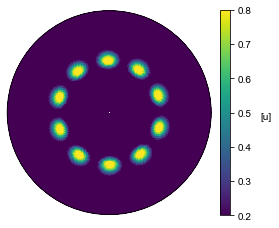

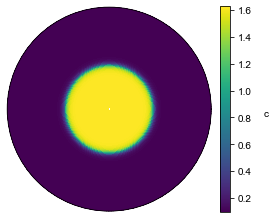

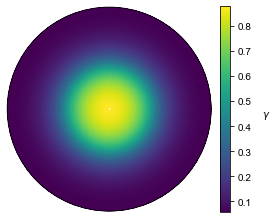

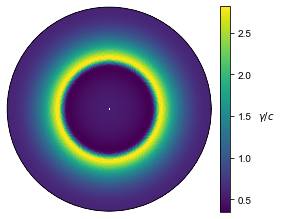

In [4]:
u = WPGAP_Coupled(params)

In [ ]:
u = WPGAP_Coupled(params)